In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df: pd.DataFrame = load("dumped_datasets/survival_all.joblib")
# df: pd.DataFrame = load("dumped_datasets/road_all.joblib")
# df: pd.DataFrame = load("dumped_datasets/hisingen_all.joblib")

df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

# display(df)

In [3]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [4]:
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# X_test, y_test = rus.fit_resample(X_test, y_test)
# bintr = np.bincount(y_train)
# binte = np.bincount(y_test)
# print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

In [5]:
name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [6]:
from pp_tools import scale_dataset

X_train_original = X_train.copy()
X_test_original = X_test.copy()

X_combined = pd.concat([X_train, X_test])

scale_dataset(X_combined)

test_len = len(X_test)
X_test = X_combined.iloc[-test_len:]
X_train = X_combined.iloc[:-test_len]

X_combined = None # Release memory

vvv RF vvv

In [7]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
# rf.fit(X_train.values, y_train)

vvv DNN vvv

In [8]:
import keras
dnn = keras.models.load_model("dnn_all_survival_imbalanced")

vvv SHAP vvv

In [9]:
import shap
import tensorflow as tf

X_sample = pd.concat([X_train[y_train == 1].sample(50, random_state=0), X_train[y_train == 0].sample(50, random_state=0)]).values

# vvv RF vvv

# exp_rf = shap.KernelExplainer(rf.predict_proba, data=X_sample, algorithm="kernel")
# exp_rf_tree = shap.TreeExplainer(rf)

# vvv DNN vvv

exp_dnn = shap.KernelExplainer(dnn.predict, data=X_sample, algorithm="kernel")
# tf.compat.v1.disable_v2_behavior()
# exp_dnn_deep = shap.DeepExplainer((dnn.layers[0].input, dnn.layers[-1].output), data=X_sample)
# exp_dnn_grad = shap.GradientExplainer((dnn.layers[0].input, dnn.layers[-1].output), data=X_sample)

Instructions for updating:
non-resource variables are not supported in the long term


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(?, 5), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")). Instead, use tensor.ref() as the key.

In [10]:
from shap_tools import *

max_samples = int(min(len(X_train), 600) / 2)

X_exp = pd.concat([X_train[y_train == 1].sample(max_samples, random_state=0), X_train[y_train == 0].sample(max_samples, random_state=0)])
# X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]
X_exp_name = name_train.loc[X_exp.index]

In [11]:
def get_explanation2(explainer, df: pd.DataFrame):
    return shap.Explanation(
        values=explainer.shap_values(df.values)[-1],
        base_values=0.5, #explainer.expected_value[-1],
        data=df.to_numpy(),
        feature_names=df.columns)

In [12]:
# shap_rf = get_explanation2(exp_rf, X_exp)
# shap_rf_tree = get_explanation2(exp_rf_tree, X_exp)

shap_dnn = get_explanation2(exp_dnn, X_exp)
# shap_dnn_deep = get_explanation2(exp_dnn_deep, X_exp)
# shap_dnn_grad = get_explanation2(exp_dnn_grad, X_exp)

# dump(shap_dnn_deep, "dumped_shap/shap_dnn_deep.joblib")

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "/home/hampus/.cache/pypoetry/virtualenvs/ml-classify-pJEs0r8S-py3.8/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 243, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/home/hampus/.cache/pypoetry/virtualenvs/ml-classify-pJEs0r8S-py3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/hampus/.cache/pypoetry/virtualenvs/ml-classify-pJEs0r8S-py3.8/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 26, in custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: Exception encountered when calling layer "layer_1" (type Dense).
    
    module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(200, 5), dtype=float32)


In [132]:
display(X_exp)

,dcs,dcs_ID,dt,dt_ID,dt_data
523160,-0.137282,-0.590974,1.402120,-0.131733,-0.275274
981713,1.194747,4.201189,0.728319,0.231076,0.100100
803170,-1.136304,-0.590974,-0.308885,-0.133661,-0.275696
1503476,-2.468332,-0.590974,-0.310893,-0.133471,-0.275749
118624,0.972742,3.927351,0.312313,0.105774,-0.066199
...,...,...,...,...,...
1150944,-0.914299,-0.590974,-0.300854,-0.114926,-0.274618
1401215,-2.357330,-0.590974,-0.304066,-0.113476,-0.271283
1073127,-0.248284,0.504378,-0.054704,-0.124587,0.071715
435492,0.084723,-0.590974,-0.256683,-0.124680,-0.273732


In [133]:
def plot_beeswarm2(exp_obj):
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="plasma"), label="Feature value")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Low", "High"])
    plt.xlim((-0.5, 0.5))
    vis = shap.plots.beeswarm(exp_obj, max_display=20, color=plt.get_cmap("plasma"), color_bar=False,
        order=[3, 1, 4, 0, 2])

In [122]:
def reform_explanation(exp_obj: shap.Explanation, mask):
    values = exp_obj.values[mask]
    base_value = exp_obj.base_values
    data = exp_obj.data[mask]
    feature_names = exp_obj.feature_names
    return shap.Explanation(
        values=values,
        base_values=base_value,
        data=data,
        feature_names=feature_names)

In [123]:
display(X_exp_name)

523160          Malfunction_dataset_SONATA
981713                   Fuzzy_dataset_KIA
803170                Flooding_dataset_KIA
1503476             Flooding_dataset_Spark
118624                Fuzzy_dataset_SONATA
                        ...               
1150944                  Fuzzy_dataset_KIA
1401215             Flooding_dataset_Spark
1073127                  Fuzzy_dataset_KIA
435492          Malfunction_dataset_SONATA
229797     FreeDrivingData_20180323_SONATA
Name: name, Length: 600, dtype: object

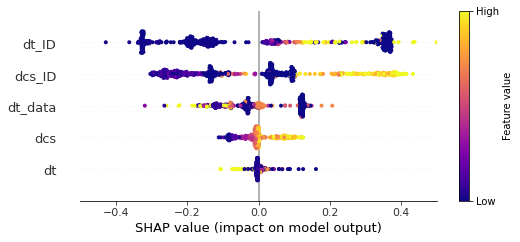

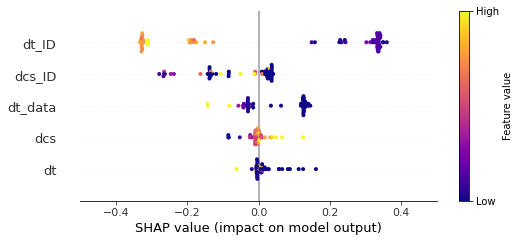

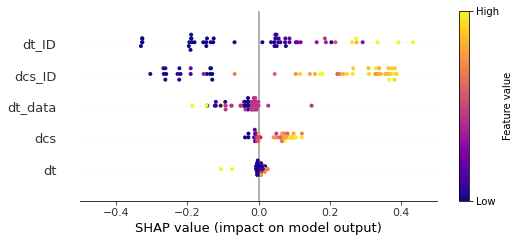

In [134]:
# plot_beeswarm2(shap_rf)
# plot_beeswarm2(shap_rf_tree)
plot_beeswarm2(shap_dnn)
X_exp_r = X_exp.reset_index(drop=True)
X_exp_name_r = X_exp_name.reset_index(drop=True)
plot_beeswarm2(reform_explanation(shap_dnn, (X_exp_name_r == "Malfunction_dataset_SONATA")))
plot_beeswarm2(reform_explanation(shap_dnn, (X_exp_name_r == "Fuzzy_dataset_SONATA")))
# plot_beeswarm2(shap_dnn_deep)
# plot_beeswarm2(shap_dnn_grad)

In [ ]:
# shap.summary_plot(shap_rf, plot_type="bar")
# shap.summary_plot(shap_rf_tree, plot_type="bar")
# shap.summary_plot(shap_dnn, plot_type="bar")
# shap.summary_plot(shap_dnn_deep, plot_type="bar")
# shap.summary_plot(shap_dnn_grad, plot_type="bar")

tata = pd.DataFrame([shap_rf, shap_rf_tree, shap_dnn, shap_dnn_deep, shap_dnn_grad])

# sns.barplot()

In [ ]:
def euclid(a, b):
    return np.sqrt(np.dot(b-a, b-a))

def cosim(a, b):
    return np.dot(a, b)/(np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))

shap_rf_avg = np.array(shap_rf.values).flatten() # np.mean(shap_rf.values, axis=0)
shap_dnn_avg = np.array(shap_dnn.values).flatten() # np.mean(shap_dnn.values, axis=0)

# print(shap_rf_avg)
# print(shap_dnn_avg)

# shap_cosims = np.sort(list(map(cosim, shap_rf.values, shap_rf_tree.values)))
# shap_cosims = list(map(cosim, shap_rf.values, shap_rf_tree.values))

all_shaps = [shap_rf, shap_rf_tree, shap_dnn, shap_dnn_deep, shap_dnn_grad]
names = ["RF_KernelExplainer", "RF_TreeExplainer", "DNN_KernelExplainer", "DNN_DeepExplainer", "DNN_GradientExplainer"]

temp = pd.DataFrame(index=names, columns=names, dtype=np.float64)
for i in range(5):
    for j in range(5):
        temp.iloc[i, j] = np.mean(list(map(cosim, all_shaps[i].values, all_shaps[j].values)))

# Drop first row and last column that don't provide information
temp.drop(index=temp.index[0], inplace=True)
temp.drop(columns=temp.columns[-1], inplace=True)

# Generate a mask for the upper triangle but not the diagonal
mask = np.triu(np.ones_like(temp, dtype=bool))
np.fill_diagonal(mask, False)

sns.heatmap(temp, annot=True, square=True, mask=mask, vmin=0.7, vmax=1, center=0.7, annot_kws={"fontsize": 12}, fmt=".3f")
plt.xticks(rotation=20, horizontalalignment="right")

# print(np.mean(shap_cosims))
# print(euclid(shap_rf_avg, shap_dnn_avg))
# plt.plot(shap_cosims)

In [137]:
def cust_exp(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, scale):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = (df_exp[feature] >= scale[0]) & (df_exp[feature] < scale[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask].copy()
    
    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values

    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    df_exp["shap_hues"] = shap_hues
    
    normal_values = df_exp.loc[df_exp["Label"] == "normal", [feature, "shap_hues"]]
    attack_values = df_exp.loc[df_exp["Label"] == "attack", [feature, "shap_hues"]]
    
    normal_hist, normal_bins = np.histogram(normal_values[feature], bins=50, range=(scale[0], scale[1]))
    attack_hist, attack_bins = np.histogram(attack_values[feature], bins=50, range=(scale[0], scale[1]))

    fig, ax = plt.subplots(dpi=100, figsize=(10, 1))
    
    max_bar = max(normal_hist.max(), attack_hist.max())
    normal_hist = normal_hist / max_bar
    attack_hist = attack_hist / max_bar

    normal_cont = ax.bar(normal_bins[:-1], normal_hist, width=(scale[1] - scale[0])/50, align="edge")
    attack_cont = ax.bar(attack_bins[:-1], -attack_hist, width=(scale[1] - scale[0])/50, align="edge")


    # display(normal_values)
    prev_edge = 0
    for i in range(1, len(normal_bins)):
        normal_hues_mean = normal_values.loc[(normal_values[feature] >= normal_bins[prev_edge]) & (normal_values[feature] < normal_bins[i]), "shap_hues"].fillna(0.5).mean()
        attack_hues_mean = attack_values.loc[(attack_values[feature] >= attack_bins[prev_edge]) & (attack_values[feature] < attack_bins[i]), "shap_hues"].fillna(0.5).mean()

        # print(shap_hues_mean)
        normal_cont.patches[i - 1].set_facecolor(cmap(normal_hues_mean))
        attack_cont.patches[i - 1].set_facecolor(cmap(attack_hues_mean))
        # attack_cont.patches[i - 1]

        prev_edge = i

    tick_unit = (scale[1] - scale[0]) / 10
    ax.set_xlim(scale[0] - 0.5*tick_unit, scale[1] + 0.5*tick_unit)
    ax.set_xticks(ticks=np.linspace(scale[0], scale[1], 11)) #, labels=map(lambda x: format(x, '.2f'), np.linspace(0, 0.02, 11)))
    ax.set_ylim(-1, 1)
    ax.set_yticks(ticks=[-0.5, 0.5], labels=["attack", "normal"])

    ax.axhline(y=0, color="black", linewidth=0.5, zorder=-1)

    plt.show()

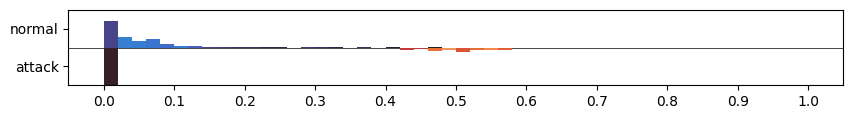

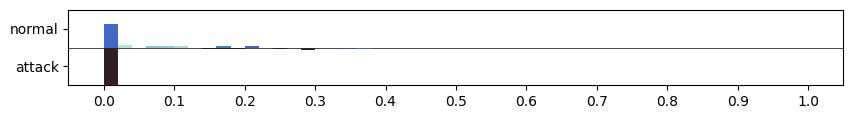

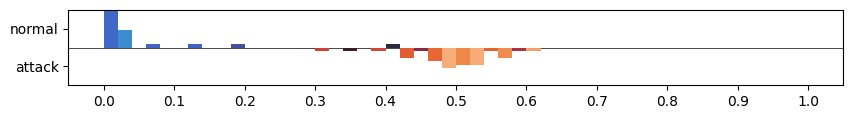

In [153]:
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", scale=(0, 0.0003))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_dnn, "dcs_ID", scale=(0, 1))
mask = (X_exp_name == "Malfunction_dataset_SONATA")
cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 1))
mask = (X_exp_name == "Fuzzy_dataset_SONATA")
cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
#     reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 0.6))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", scale=(0, 0.02))